In [25]:
import tensorflow as tf
import os
import cv2
import numpy as np

In [2]:
import csv

train_dict = {}

with open('train_labels.csv', newline='') as csvfile:
    rows = csv.reader(csvfile)
    for row in rows:
        train_dict[str(row[0])] = row[1] 

In [3]:
print(train_dict['1'])
print(train_dict['2'])

6
9


In [4]:
path = "./train"
nrows = 32
ncols = 32

In [5]:
dirs = os.listdir(path)

In [16]:
data_X = []
data_y = []
dirs = os.listdir(path)
for pic_name in dirs:
    img = cv2.resize(cv2.imread(path+"/"+pic_name) ,(nrows,ncols), interpolation=cv2.INTER_CUBIC)
    data_X.append(img)
    data_y.append(train_dict[str.split(pic_name, '.')[0]])
data_X = np.array(data_X)
data_y = np.array(data_y)  

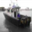

8


In [17]:
from PIL import Image
from IPython.display import display
# airplane -0 automobile -1 bird -2 cat -3 deer -4 dog -5 frog -6 horse -7 ship -8 truck -9
display(Image.fromarray(data_X[0].astype('uint8')))
print(data_y[0])

In [7]:
data_y = tf.keras.utils.to_categorical(data_y)

In [8]:
data_X.shape

(47500, 32, 32, 3)

In [ ]:
data_X = data_X.astype('float16')
data_y = data_y.astype('float16')  

In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.1, random_state=42)

In [10]:
x_test = x_train
y_test = y_train

In [23]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(42750, 32, 32, 3)
(4750, 32, 32, 3)
(42750,)
(4750,)


In [12]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.utils as np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

In [26]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate
 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)
 
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)
 
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()
 
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)
 
#training
batch_size = 64
 
opt_rms = keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=125,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])
#save to disk
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('model.h5') 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_18 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [33]:
import re
p1 = re.compile(r'[(](.*?)[)]', re.S)

unlabel_X=[]
ID = []
dirs_t = os.listdir('./finaltest')
for pic_name in dirs_t:
    img = cv2.resize(cv2.imread("./finaltest/"+pic_name) ,(nrows,ncols), interpolation=cv2.INTER_CUBIC)
    unlabel_X.append(img)
    ID.append(re.findall(p1, pic_name))
unlabel_X = np.array(unlabel_X)
unlabel_X = unlabel_X.astype('float16')

In [29]:
u_mean = np.mean(unlabel_X,axis=(0,1,2,3))
u_std = np.std(unlabel_X,axis=(0,1,2,3))

In [34]:
unlabel_X = (unlabel_X-mean)/(std+1e-7)

In [35]:
unlabel_y = model.predict(unlabel_X)

In [36]:
o = unlabel_y.argmax(axis=1)
print(o)
print(ID)

[1 2 9 ... 1 6 7]
[['1270'], ['1407'], ['1861'], ['2'], ['215'], ['2175'], ['2442'], ['548'], ['909'], ['1'], ['10'], ['100'], ['1000'], ['1001'], ['1002'], ['1003'], ['1004'], ['1005'], ['1006'], ['1007'], ['1008'], ['1009'], ['101'], ['1010'], ['1011'], ['1012'], ['1013'], ['1014'], ['1015'], ['1016'], ['1017'], ['1018'], ['1019'], ['102'], ['1020'], ['1021'], ['1022'], ['1023'], ['1024'], ['1025'], ['1026'], ['1027'], ['1028'], ['1029'], ['103'], ['1030'], ['1031'], ['1032'], ['1033'], ['1034'], ['1035'], ['1036'], ['1037'], ['1038'], ['1039'], ['104'], ['1040'], ['1041'], ['1042'], ['1043'], ['1044'], ['1045'], ['1046'], ['1047'], ['1048'], ['1049'], ['105'], ['1050'], ['1051'], ['1052'], ['1053'], ['1054'], ['1055'], ['1056'], ['1057'], ['1058'], ['1059'], ['106'], ['1060'], ['1061'], ['1062'], ['1063'], ['1064'], ['1065'], ['1066'], ['1067'], ['1068'], ['1069'], ['107'], ['1070'], ['1071'], ['1072'], ['1073'], ['1074'], ['1075'], ['1076'], ['1077'], ['1078'], ['1079'], ['108'], [

In [40]:
table = []
table.append(["ID","Class"])
for i,num in enumerate(o):
    table.append([ int(ID[i][0]), int(num)])

In [41]:
import csv
with open('output.csv', 'w', newline='') as csvfile:
  writer = csv.writer(csvfile)

  writer.writerows(table)

In [79]:
!ls

coic3.zip  finaltest  output.csv  sample_data  train  train_labels.csv
